K-Arm Bandits



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BernoulliBandit:
    def __init__(self, p, verbose=False):
        self.p = p
        self.verbose = verbose

    def pull(self):
        # Simulate pulling the arm of the bandit
        return np.random.random() < self.p

In [3]:
class PoissonBandit:
    def __init__(self, lambda_, verbose=False):
        self.lambda_ = lambda_
        self.verbose = verbose

    def pull(self):
        # Simulate pulling the arm of the bandit
        return np.random.poisson(self.lambda_)

In [4]:
class Strategy:
    def __init__(self, bandits, T):
        self.bandits = bandits
        self.T = T
        self.rewards = np.zeros(T)

    def run(self):
        pass  # To be implemented by subclasses

In [5]:
class StandardStochastic(Strategy):
    def run(self):
        for t in range(self.T):
            chosen_bandit = np.random.choice(self.bandits)
            reward = chosen_bandit.pull()
            self.rewards[t] = reward

## Epsilon-First Strategy 

The `EpsilonFirst` class implements an epsilon-first strategy where a portion of the total time steps (defined by `epsilon`) is allocated to exploring the arms of the bandits. During this exploration phase, bandits are selected randomly to gather initial data on their expected rewards. The remaining time is spent exploiting the bandit with the highest estimated value, determined during the exploration phase.

### Pseudo-Code Outline

1. **Initialization**:
   - Set exploration time based on `epsilon`.
   - Initialize counters and value estimates.

2. **Exploration Phase**:
   - Randomly select and pull bandits, update estimates.

3. **Exploitation Phase**:
   - Select the bandit with the highest estimated value and pull.

``` python
# Some pseudo code:
# Initialize exploration time, estimated_values, counts
# For t in range(exploration_time):
#     Randomly select a bandit, pull arm, update counts and estimated_values
# For t in range(exploration_time, T):
#     Select bandit with max estimated_value, pull arm


In [6]:
class EpsilonFirst(Strategy):
    def __init__(self, bandits, T, epsilon):
        super().__init__(bandits, T)
        self.epsilon = epsilon
        self.exploration_time = int(epsilon * T)
        self.estimated_values = np.zeros(len(bandits))
        self.counts = np.zeros(len(bandits))

    def run(self):
        # Exploration phase
        for t in range(self.exploration_time):
            chosen_bandit = np.random.choice(self.bandits)
            reward = chosen_bandit.pull()
            self.rewards[t] = reward
            bandit_index = self.bandits.index(chosen_bandit)
            self.counts[bandit_index] += 1
            self.estimated_values[bandit_index] += (reward - self.estimated_values[bandit_index]) / self.counts[bandit_index]

        # Exploitation phase
        for t in range(self.exploration_time, self.T):
            chosen_bandit = self.bandits[np.argmax(self.estimated_values)]
            reward = chosen_bandit.pull()
            self.rewards[t] = reward

## Epsilon-Greedy Strategy 

The `EpsilonGreedy` class implements the epsilon-greedy strategy, where the algorithm explores randomly selected bandits with a probability of `epsilon`, and exploits the best-known bandit otherwise. This approach balances exploration and exploitation throughout the entire duration of the trials, rather than separating them into distinct phases.

### Pseudo-Code Outline

1. **Initialization**:
   - Set `epsilon` for exploration probability.
   - Initialize counters and value estimates.

2. **Run Phase**:
   - For each time step, decide to explore or exploit:
     - **Explore**: Select a random bandit.
     - **Exploit**: Select the bandit with the highest estimated value.
   - Pull the selected bandit's arm, update counts, and value estimates.

```python
# Pseudo-code
# Initialize epsilon, estimated_values, counts
# For t in range(T):
#     if random < epsilon:
#         Randomly select a bandit, pull arm
#     else:
#         Select bandit with max estimated_value, pull arm
#     Update counts and estimated_values


In [7]:
class EpsilonGreedy(Strategy):
    def __init__(self, bandits, T, epsilon):
        super().__init__(bandits, T)
        self.epsilon = epsilon
        self.estimated_values = np.zeros(len(bandits))
        self.counts = np.zeros(len(bandits))

    def run(self):
        for t in range(self.T):
            if np.random.random() < self.epsilon:
                chosen_bandit = np.random.choice(self.bandits)
            else:
                chosen_bandit = self.bandits[np.argmax(self.estimated_values)]

            reward = chosen_bandit.pull()
            self.rewards[t] = reward
            bandit_index = self.bandits.index(chosen_bandit)
            self.counts[bandit_index] += 1
            self.estimated_values[bandit_index] += (reward - self.estimated_values[bandit_index]) / self.counts[bandit_index]


In [8]:
# Helper function to run simulations
def run_simulation(strategy_class, bandit_class, K, T, N, epsilon=None, runs=100, games=10):
    all_rewards = np.zeros((games, T))
    for game in range(games):
        game_rewards = np.zeros(T)
        for run in range(runs):
            bandits = [bandit_class(np.random.uniform()) for _ in range(K)]
            if epsilon is None:
                strategy = strategy_class(bandits, T)
            else:
                strategy = strategy_class(bandits, T, epsilon)
            strategy.run()
            game_rewards += strategy.rewards
        all_rewards[game] = game_rewards / runs
    return all_rewards.mean(axis=0)

In [9]:
# Parameters 
K = 3
T = 1000
N = 5
games = 10
runs = 100

In [10]:
epsilon = N * K / T

In [11]:
stochastic_rewards = run_simulation(StandardStochastic, BernoulliBandit, K, T, N, runs=runs, games=games)


In [12]:
epsilon_first_rewards = run_simulation(EpsilonFirst, BernoulliBandit, K, T, N, epsilon=epsilon, runs=runs, games=games)


In [13]:
epsilon_greedy_rewards = run_simulation(EpsilonGreedy, BernoulliBandit, K, T, N, epsilon=epsilon, runs=runs, games=games)


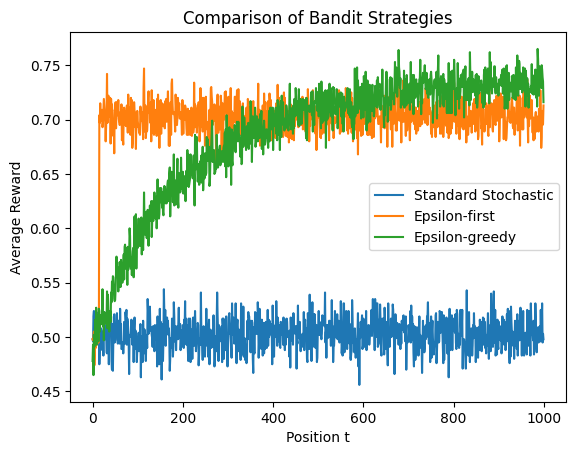

In [14]:
plt.plot(stochastic_rewards, label='Standard Stochastic')
plt.plot(epsilon_first_rewards, label='Epsilon-first')
plt.plot(epsilon_greedy_rewards, label='Epsilon-greedy')
plt.xlabel('Position t')
plt.ylabel('Average Reward')
plt.title('Comparison of Bandit Strategies')
plt.legend()
plt.show()

### Observations:

1. **Standard Stochastic Strategy**:
   - Exhibits a relatively low and consistent reward around 0.50 throughout the time steps.
   - This strategy involves random selection, leading to steady but suboptimal rewards.

2. **Epsilon-first Strategy**:
   - Shows a sharp increase in the average reward early on, stabilizing around 0.70.
   - The exploration phase allows gathering sufficient information, followed by consistent exploitation of the best-known option.

3. **Epsilon-greedy Strategy**:
   - Similar to the Epsilon-first strategy, it demonstrates an initial learning phase with increasing rewards.
   - It stabilizes slightly above the Epsilon-first strategy, with rewards oscillating around 0.72.
   - This strategy continuously balances exploration and exploitation, allowing for slight improvements over time.

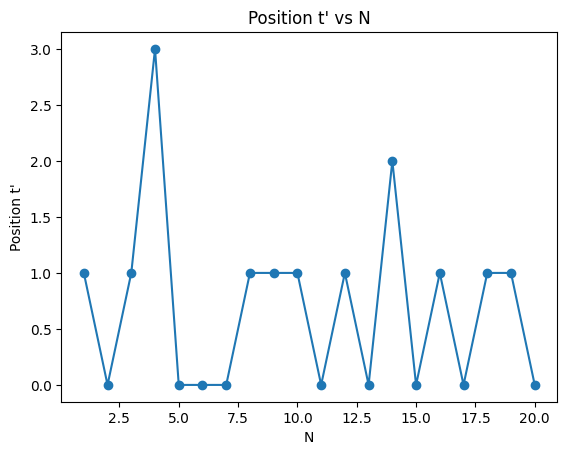

In [15]:
N_values = range(1, 21)
t_prime = []

for N in N_values:
    epsilon = N * K / T
    epsilon_first_rewards = run_simulation(EpsilonFirst, BernoulliBandit, K, T, N, epsilon=epsilon, runs=runs, games=games)
    epsilon_greedy_rewards = run_simulation(EpsilonGreedy, BernoulliBandit, K, T, N, epsilon=epsilon, runs=runs, games=games)
    
    # Find the position t' where epsilon-greedy starts outperforming epsilon-first
    t_prime.append(np.argmax(epsilon_greedy_rewards > epsilon_first_rewards))

plt.plot(N_values, t_prime, marker='o')
plt.xlabel('N')
plt.ylabel('Position t\'')
plt.title('Position t\' vs N')
plt.show()

 Position t' vs N

The first graph illustrates the relationship between \( N \) (the number of exploration phases) and \( t' \) (the position where Epsilon-greedy starts outperforming Epsilon-first). 

#### Observations:
- There is no consistent trend observed in the value of \( t' \) as \( N \) increases.
- The value of \( t' \) fluctuates, occasionally reaching up to 3 and sometimes being 0.
- This variability suggests that the point at which Epsilon-greedy begins to outperform Epsilon-first is not strongly dependent on \( N \) in a straightforward manner.

In [16]:
poisson_rewards = run_simulation(StandardStochastic, PoissonBandit, K, T, N, runs=runs, games=games)


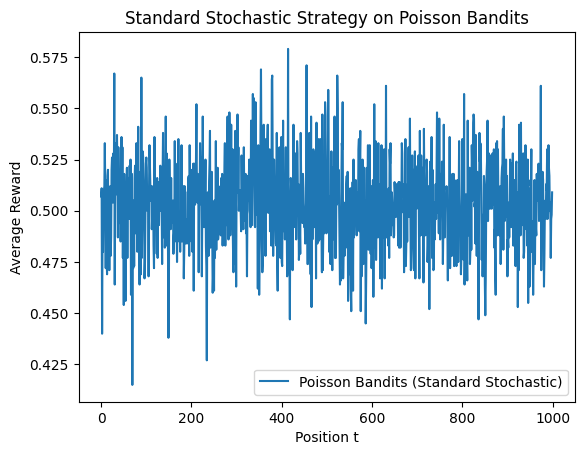

In [17]:
plt.plot(poisson_rewards, label='Poisson Bandits (Standard Stochastic)')
plt.xlabel('Position t')
plt.ylabel('Average Reward')
plt.title('Standard Stochastic Strategy on Poisson Bandits')
plt.legend()
plt.show()

Standard Stochastic Strategy on Poisson Bandits

The second graph shows the performance of the Standard Stochastic strategy when applied to Poisson bandits, measured by the average reward obtained at each position \( t \).

#### Observations:
- The average reward fluctuates around 0.5, with considerable variance.
- The reward distribution shows higher peaks compared to Bernoulli bandits due to the nature of Poisson distribution, which can yield higher reward values.
- There is no clear trend or improvement in rewards over time, which is consistent with the nature of the Standard Stochastic strategy.

### Conslusion
The experiments conducted illustrate different strategies for solving the k-armed bandit problem. The Epsilon-greedy strategy generally performs better than Epsilon-first, with fluctuations in when it begins to outperform based on \( N \). The Standard Stochastic strategy, while simple, shows limited performance, particularly in environments with Poisson-distributed rewards. The results highlight the importance of balancing exploration and exploitation in reinforcement learning strategies. The varied performance across strategies and settings underscores the need to tailor approaches based on the problem's characteristics.
